<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# openEO Platform

## Advanced data processing
### Snow monitoring

In [2]:
from eo_utils import *
from openeo.processes import eq
import rioxarray

Before starting, please check to have the latest version of openeo installed:

In [ ]:
!pip install openeo --upgrade

Connect to openEO Platform and authenticate using EGI

In [76]:
# backend = 'https://openeo.cloud'
backend = 'https://openeo-dev.vito.be'
conn = openeo.connect(backend).authenticate_oidc('egi')

Authenticated using refresh token.


## Area of Interest selection
Run the next cell, click on the rectangle button and then draw the area over the map like in the following example image
<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/selection_bbox.jpg"
     alt="rectangle_selection"
     style="float: left; margin-right: 10px;" />

In [4]:
center = [46.49, 11.35]
zoom = 12

eoMap = openeoMap(center,zoom)
eoMap.map

Map(center=[46.49, 11.35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

Get the bounding box from the previous map.

In [104]:
bbox = eoMap.getBbox()
print('west',bbox[0],'\neast',bbox[2],'\nsouth',bbox[1],'\nnorth',bbox[3])

west 9.663849 
east 10.200806 
south 46.009728 
north 46.135486


In [29]:
spatial_extent  = {'west': 9.663849, 'east': 10.200806, 'south': 46.009728, 'north': 46.135486}

### Snow mask generation with Sentinel-2 SCL layer (Scene Classification)

You can find more information about the Sentinel-2 SCL layer here https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm

If you want to know more about the Sentinel-2 L2A collection, uncomment and run the next cell.

In [16]:
# conn.describe_collection('SENTINEL2_L2A') 

In [191]:
collection      = 'SENTINEL2_L2A'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
temporal_extent = ['2020-11-01', '2021-06-30']
bands           = ['SCL']

S2_SCL = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

The apply operator is used here to generate a boolean mask based on the SCL layer. Where SCL has value 11 (snow and ice), our mask will be set to 1.

In [192]:
S2_SCL_snow = S2_SCL.apply(lambda x: x == 11)

We can use aggregate_temporal_period to get a weekly snow mask.

More information about `aggregate_temporal_period` can be found here:

https://processes.openeo.org/#aggregate_temporal_period

https://open-eo.github.io/openeo-python-client/api.html?highlight=aggregate_temporal_period#openeo.rest.datacube.DataCube.aggregate_temporal_period

In [193]:
S2_SCL_snow_weekly = S2_SCL_snow.aggregate_temporal_period(period='week',reducer='max')

We remove the band dimension, since the band label 'SCL' would not fully match the data content anymore.

In [194]:
S2_SCL_snow_weekly = S2_SCL_snow_weekly.drop_dimension('bands')

We can now download the result with a sync call.

Please note: this works only for limited areas. For larger processing use a batch job instead.

In [109]:
S2_SCL_snow_weekly.download('S2_SCL_snow_weekly_Sondrio.nc')

Using xArray, we can open and visualize our result:

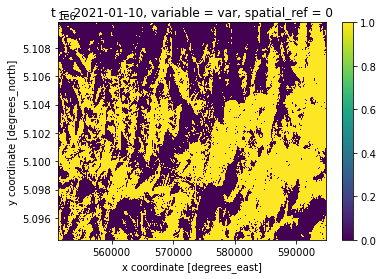

In [190]:
S2_SCL_snow_weekly_ds = xr.open_dataset('S2_SCL_snow_weekly_Sondrio.nc')
S2_crs = S2_SCL_snow_weekly_ds.crs.attrs['crs_wkt']
S2_SCL_snow_weekly_ds = S2_SCL_snow_weekly_ds.drop('crs').to_array().rio.write_crs(S2_crs)[0]
S2_SCL_snow_week = S2_SCL_snow_weekly_ds.loc[dict(t=S2_SCL_snow_weekly_ds.t[11])]
S2_SCL_snow_week.plot.imshow()

### Optical RGB composite for visual reference

In [12]:
collection      = 'SENTINEL2_L2A'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
temporal_extent = ['2021-01-01', '2021-01-31']
bands           = ['B02','B03','B04']

S2_BGR = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)
S2_BGR = S2_BGR.reduce_dimension(dimension='t',reducer='min')
S2_BGR.download('S2_BGR.nc')

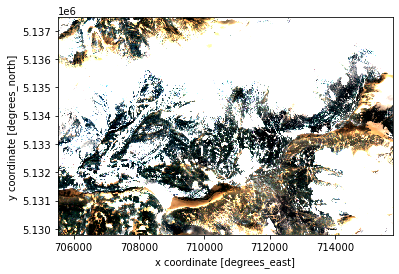

In [13]:
S2_BGR = xr.open_dataset('S2_BGR.nc')
S2_BGR = S2_BGR.rio.write_crs(S2_BGR.crs.attrs['crs_wkt'])
S2_BGR = (S2_BGR.drop('crs').to_array() / 2000).clip(0,1)
S2_BGR.plot.imshow()

### Snow mask generation with MODIS NDSI

Sentinel-2 (A and B) have together a revisit time of 5 days.

This means that data for our area of interest is not updated daily. Therefore, if we would need to get a daily snow cover map, we should use a different data source.

MODIS is designed to provide atleast daily observations, but it has a coarser resolution (~500m) compared to Sentinel-2 (10:60m).

If you want to know more about the MODIS collection, uncomment and run the next cell.

In [14]:
#conn.describe_collection('MODIS') 

In [77]:
collection      = 'MODIS'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
temporal_extent = ['2020-11-01', '2021-06-30']
bands           = ['B04','B06']

MODIS_green_swir  = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

We can compute the NDSI (Normalized Difference Snow Index) using the green (B04) and swir (B06) bands of MODIS.

Additional information about MODIS and the NDSI usage for snow detection can be found here: https://modis-snow-ice.gsfc.nasa.gov/uploads/C6_MODIS_Snow_User_Guide.pdf

In [78]:
MODIS_NDSI = ( MODIS_green_swir.band('B04') - MODIS_green_swir.band('B06')) / (MODIS_green_swir.band('B04') + MODIS_green_swir.band('B06'))

MODIS acquires data every day, but we would like to compare the result with Sentinel-2. We can again aggregate with a weekly period to align and compare the results.

We compute the maximum value of the NDSI over a week:

In [79]:
MODIS_NDSI_weekly = MODIS_NDSI.aggregate_temporal_period(period='week',reducer='max')

and we consider as covered by snow all the pixels with an NDSI value greater than 0.4:

In [80]:
MODIS_snow_weekly = MODIS_NDSI_weekly.apply(lambda x: x > 0.4)

In [81]:
MODIS_snow_weekly.download('MODIS_snow_weekly2.nc')

Now our snow mask is ready. However, if we want to compare it with the Sentinel-2 one, we would need to apply one last step.

MODIS has a different resolution and projection compared to Sentinel-2 and therefore we need to resample MODIS to align with Sentinel-2:

In [20]:
MODIS_snow_weekly = xr.open_dataset('MODIS_snow_weekly.nc')
MODIS_crs = MODIS_snow_weekly.crs.attrs['crs_wkt']
MODIS_snow_weekly = MODIS_snow_weekly.drop('crs').to_array().rio.write_crs(4326)[0]

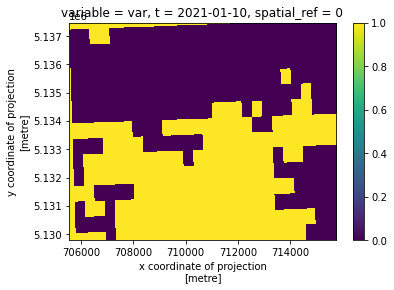

In [49]:
MODIS_snow_weekly_UTM = MODIS_snow_weekly[10].rio.reproject_match(S2_SCL_snow_week)
MODIS_snow_weekly_UTM.clip(0,1).plot.imshow()

Note: the snow mask obtained with MODIS does not consider clouds whereas the SCL layer of Sentinel-2 has been processed by a dedicated algorithm.

The alignment of MODIS and Sentinel-2 can be performed also in openEO using `resample_cube_spatial`.

https://processes.openeo.org/#resample_cube_spatial

`MODIS_snow_weekly_UTM = MODIS_snow_weekly.resample_cube_spatial(S2_SCL_snow_weekly)`

### Wetsnow detection using Sentinel-1

Please refer to https://github.com/Open-EO/openeo-usecases/tree/master/eurac_wetsnow_usecase for more information about the original use case.

The Sentinel-1 collection we will use is not global, please have a look here to check if the area you are interested in is covered:

https://editor.openeo.cloud/?preview-collection=S1_GRD_SIGMA0_ASCENDING

https://editor.openeo.cloud/?preview-collection=S1_GRD_SIGMA0_DESCENDING

In [195]:
collection      = 'S1_GRD_SIGMA0_DESCENDING'
bands           = ["VV","VH"]
temporal_extent = ['2020-11-01', '2021-06-30']

In [196]:
s1_vvvh = conn.load_collection(
    collection,
    spatial_extent=spatial_extent, 
    bands=["VV", "VH"],
    temporal_extent=temporal_extent,
).apply(lambda x: 10 * x.log(base=10))

s1_angle = conn.load_collection(
    collection,
    spatial_extent=spatial_extent, 
    bands=["angle"],
    temporal_extent=["2020-11-01", "2020-11-10"],
)

In the first step every timestep of the Sentinel-1 backscatter data is normalized with the mean of the time series for the two polarizations VV and VH.

In [197]:
rat_vvvh = s1_vvvh.merge_cubes(s1_vvvh.mean_time(), overlap_resolver="subtract")

In the second step the Sentinel-1 local incident angle is classified into a weight layer.

In [198]:
s1_lia_angle = s1_angle.min_time().band("angle") / 1000

theta_1 = 20
theta_2 = 45
k = 0.5

weight = (
    (0.5 * ((theta_2 - s1_lia_angle) * 0.04 + 1))
    .mask(s1_lia_angle < theta_1, replacement=1)
    .mask(s1_lia_angle < theta_2, replacement=k)
)

The time series of the normalized backscatter images and the weight layer are combined in a thrid step to retrieve a wet snow map solely based on Sentinel-1 data.

In [208]:
rc_cube = rat_vvvh.merge_cubes(weight)

from openeo.metadata import Band
rc_cube.metadata = rc_cube.metadata.append_band(Band("angle"))

rc_w = rc_cube.band("angle")
rc = rc_w * rc_cube.band("VH") + (1-rc_w) * rc_cube.band("VV")

wetsnow = rc.mask(rc <= -2,replacement = 10).mask(rc > -2,replacement = 20)

Now the Sentinel-1 based wetsnow map is ready. The final step will consist in using the Sentinel-2 based snow mask to create a final product:

In [209]:
wetsnow_masked = wetsnow.filter_temporal(temporal_extent).merge_cubes(S2_SCL_snow_weekly.filter_temporal(temporal_extent),overlap_resolver='multiply')

In [ ]:
wetsnow_masked.download('WETSNOW_Sondrio_DSC_2020_2021_meantime_classified_masked_filter_temporal.nc')

In [3]:
xr.open_dataset('WETSNOW_Sondrio_DSC_2020_2021_meantime_classified_masked_filter_temporal.nc')

<xarray.Dataset>
Dimensions:  (t: 61, x: 4352, y: 1536)
Coordinates:
  * t        (t) datetime64[ns] 2020-11-01 2020-11-02 ... 2021-06-27 2021-06-30
  * x        (x) float64 5.513e+05 5.513e+05 5.513e+05 ... 5.948e+05 5.948e+05
  * y        (y) float64 5.11e+06 5.11e+06 5.11e+06 ... 5.094e+06 5.094e+06
Data variables:
    crs      |S1 ...
    var      (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.8
    institution:  openEO platform

In [ ]:
xr.open_dataset('WETSNOW_Sondrio_DSC_2020_2021_meantime_classified_masked_filter_temporal.nc')

In [ ]:
snow_mask = xr.open_dataset('S2_SCL_snow_weekly_Sondrio_aligned.nc').drop('crs') > 0
snow_mask

<xarray.Dataset>
Dimensions:  (t: 34, x: 4352, y: 1536)
Coordinates:
  * t        (t) datetime64[ns] 2020-11-08 2020-11-15 ... 2021-06-20 2021-06-27
  * x        (x) float64 5.513e+05 5.513e+05 5.513e+05 ... 5.948e+05 5.948e+05
  * y        (y) float64 5.11e+06 5.11e+06 5.11e+06 ... 5.094e+06 5.094e+06
Data variables:
    var      (t, y, x) bool False False False False ... False False False False
Attributes:
    Conventions:  CF-1.8
    institution:  openEO platform

In [177]:
wetsnow_masked = wetsnow.where(snow_mask)

In [172]:
wetsnow_masked

<xarray.Dataset>
Dimensions:  (t: 34, x: 4352, y: 1536)
Coordinates:
  * t        (t) datetime64[ns] 2020-11-08 2020-11-15 ... 2021-06-20 2021-06-27
  * x        (x) float64 5.513e+05 5.513e+05 5.513e+05 ... 5.948e+05 5.948e+05
  * y        (y) float64 5.11e+06 5.11e+06 5.11e+06 ... 5.094e+06 5.094e+06
Data variables:
    var      (t, y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [180]:
wetsnow_masked.astype(np.uint8).to_netcdf('Wetsnow_Sondrio_masked_uint8.nc')

In [18]:
S1_VV = S1_VV_VH.filter_bands('VV').drop_dimension('bands')
S1_VV_max_t = S1_VV.max_time()
S1_VH = S1_VV_VH.filter_bands('VH').drop_dimension('bands')
S1_VH_max_t = S1_VH.max_time()

In [19]:
RAT_VV = S1_VV.merge_cubes(S1_VV_max_t,overlap_resolver='subtract')
RAT_VH = S1_VH.merge_cubes(S1_VH_max_t,overlap_resolver='subtract')

In [20]:
theta_1 = 20
theta_2 = 45
k = 0.5

S1_LIA = S1_angle.filter_bands('angle').drop_dimension('bands').min_time() / 1000 # The angle is scaled, I need to divide it by 1000 or change the threshold values
S1_LIA_cond_1 = S1_LIA < theta_1
S1_LIA_cond_2 = S1_LIA > theta_2

def cond_3(x, context = None):
    return ( ( x * (-1) + theta_2 ) * 0.04 + 1 ) * 0.5

S1_LIA_cond_3 = S1_LIA.apply(process = cond_3)

W = S1_LIA_cond_3.mask(S1_LIA_cond_1,replacement=1).mask(S1_LIA_cond_2,replacement=k)

In [21]:
RC = W*RAT_VH + (W*(-1)+1)*RAT_VV

In [22]:
s1bs_netcdf = RC.save_result(format="NetCDF")

[3] Save process as final step, here we use NetCDF as output format.

In [18]:
s1bs_netcdf = s1.save_result(format="NetCDF")

[4] Now we will create a batch job and start it. More info about batch jobs can be found here:

https://openeo.org/documentation/1.0/glossary.html#data-processing-modes

https://open-eo.github.io/openeo-python-client/batch_jobs.html

In [23]:
job_s1 = s1bs_netcdf.create_job(title="RC_DSC_Adamello_W")
job_id_s1 = job_s1.job_id
if job_id_s1:
    print("Batch job created with id: ",job_id_s1)
    job_s1.start_job()
else:
    print("Error! Job ID is None")

Batch job created with id:  vito-0ff44841-cc03-4089-9e9a-8eb936ab59b3


In [ ]:
job_s1

In [4]:
conn.list_jobs()

[{'created': '2022-05-06T13:24:22Z',
  'id': 'vito-4079158b-5156-412f-ab8c-8ae1cd9e61c7',
  'status': 'error',
  'title': 'S1_DSC_TERRASCOPE',
  'updated': '2022-05-06T13:28:26Z'},
 {'created': '2022-03-21T13:40:25Z',
  'id': 'vito-ae772416-3395-4fa4-bf83-ce022b861859',
  'status': 'finished',
  'title': 'S2_sample_job',
  'updated': '2022-03-21T13:41:03Z'},
 {'created': '2022-05-11T07:43:13Z',
  'id': 'vito-6d957bee-2e68-47c6-a0d5-1b1b55482693',
  'status': 'finished',
  'title': 'S1_sigma0_W_4',
  'updated': '2022-05-11T07:44:00Z'},
 {'created': '2022-05-11T13:25:37Z',
  'id': 'vito-8174a722-4314-46be-926a-ef879145e527',
  'status': 'finished',
  'title': 'W_DSC_Adamello_W',
  'updated': '2022-05-11T13:26:21Z'},
 {'created': '2022-05-11T13:13:51Z',
  'id': 'vito-03c839c5-5687-4dcf-b1b2-def6c35aff43',
  'status': 'error',
  'title': 'RC_DSC_Adamello_W',
  'updated': '2022-05-11T13:14:54Z'},
 {'created': '2022-04-27T12:20:06Z',
  'id': 'vito-e449a5fe-853d-45f9-8751-341daed87065',
  'status': 'finished',
  'title': 'aggregate_csv_2',
  'updated': '2022-04-27T12:27:55Z'},
 {'created': '2022-05-11T07:32:34Z',
  'id': 'vito-1fd3095a-cef7-4593-a3fe-982d096eb609',
  'status': 'finished',
  'title': 'S1_sigma0_W_3',
  'updated': '2022-05-11T07:35:22Z'},
 {'created': '2022-05-06T10:20:19Z',
  'id': 'vito-7aab8c66-bb5b-4d5d-a3c5-523d61364296',
  'status': 'finished',
  'title': 'S3_SLSTR_data',
  'updated': '2022-05-06T10:23:18Z'},
 {'created': '2022-05-09T14:31:18Z',
  'id': 'vito-d4970a5d-05fe-4f4d-93c1-6261fb57c66e',
  'status': 'finished',
  'title': 'S1_sigma0_DSC_Adamello',
  'updated': '2022-05-09T14:34:08Z'},
 {'created': '2022-05-09T15:23:48Z',
  'id': 'vito-7bbc9fb3-1548-4cda-8866-7ac1ff535971',
  'status': 'finished',
  'title': 'S1_VV',
  'updated': '2022-05-09T15:25:37Z'},
 {'created': '2022-04-27T12:22:23Z',
  'id': 'vito-bd64d554-a921-405c-bd41-6d2ab76b8cec',
  'status': 'finished',
  'title': 'aggregate_json',
  'updated': '2022-04-27T12:27:47Z'},
 {'created': '2022-05-06T12:21:32Z',
  'id': 'vito-3dc7e230-78ee-4f30-9e23-dc6675c0511c',
  'status': 'finished',
  'title': 'S3_SLSTR_NDSI',
  'updated': '2022-05-06T12:24:11Z'},
 {'created': '2022-05-11T08:33:32Z',
  'id': 'vito-9f675355-81c2-4f7b-9788-3ffa385a1b25',
  'status': 'finished',
  'title': 'S1_LIA',
  'updated': '2022-05-11T08:34:57Z'},
 {'created': '2022-05-10T14:39:14Z',
  'id': 'vito-29562189-66fd-4fa3-917e-9ad631cfb664',
  'status': 'error',
  'title': 'S1_sigma0_DSC_Adamello_W',
  'updated': '2022-05-10T14:39:49Z'},
 {'created': '2022-05-03T10:15:36Z',
  'id': 'vito-1662d42e-0227-4e6c-9a9c-4ec01501968f',
  'status': 'finished',
  'title': 'vito_worldcover_sample',
  'updated': '2022-05-03T10:19:20Z'},
 {'created': '2022-05-09T14:56:38Z',
  'id': 'vito-56fe41a8-3f66-48d7-ab75-3c4e7fc08efd',
  'status': 'finished',
  'title': 'S1_merge_cubes',
  'updated': '2022-05-09T15:02:52Z'},
 {'created': '2022-05-09T14:20:44Z',
  'id': 'vito-056e038b-06eb-4931-80a6-0d1256747950',
  'status': 'finished',
  'title': 'S1_DSC_TERRASCOPE_2',
  'updated': '2022-05-09T14:23:20Z'},
 {'created': '2022-04-27T12:08:06Z',
  'id': 'vito-a9405778-edb0-4d96-8047-9c8124acb87a',
  'status': 'finished',
  'title': 'aggregate_csv',
  'updated': '2022-04-27T12:11:43Z'},
 {'created': '2022-05-06T08:37:20Z',
  'id': 'vito-a5df9ab8-2a5e-4885-b03d-a87c22c0c478',
  'status': 'finished',
  'title': 'MODIS_data',
  'updated': '2022-05-06T08:38:04Z'},
 {'created': '2022-05-06T12:47:58Z',
  'id': 'vito-3f1df4cc-d85e-454d-8d3d-40c7db37386a',
  'status': 'error',
  'title': 'S1_ASC_TERRASCOPE_3',
  'updated': '2022-05-06T12:49:43Z'},
 {'created': '2022-03-24T09:15:42Z',
  'id': 'vito-7f286e49-970c-4761-b64d-1e14e95386e0',
  'status': 'finished',
  'title': 'VH0_result_Resample60_average',
  'updated': '2022-03-24T09:19:26Z'},
 {'created': '2022-05-11T12:55:06Z',
  'id': 'vito-0ff44841-cc03-4089-9e9a-8eb936ab59b3',
  'status': 'error',
  'title': 'RC_DSC_Adamello_W',
  'updated': '2022-05-11T12:55:57Z'

In [5]:
job = conn.job('vito-3dc7e230-78ee-4f30-9e23-dc6675c0511c')
results = job.get_results()
results.download_files('S3_SLSTR_NDSI')

[PosixPath('S3_SLSTR_NDSI/openEO.nc')]

In [9]:
NDSI = xr.open_dataset('S3_SLSTR_NDSI/openEO.nc')
NDSI.var[0].plot()

TypeError: 'method' object is not subscriptable

In [140]:
np.count_nonzero(np.isnan(W))

0

In [131]:
xr.open_dataset('W_3/openEO.nc').angle.max()

<xarray.DataArray 'angle' ()>
array(1., dtype=float32)

In [43]:
job = conn.job('vito-7bbc9fb3-1548-4cda-8866-7ac1ff535971')

If our area of interest is small, we can also do a direct request, but this will not return the CARD4L json metadata. 

Note that this step automatically adds the save_result process at the end based on the output format we choose.

In [44]:
results = job.get_results()
results.download_files('S1_VV')

[PosixPath('S1_VV/openEO.nc')]

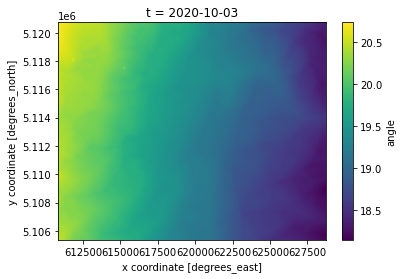

In [66]:
VV = xr.open_dataset('result_0/openEO.nc')
(VV.angle[0]/1000).plot()

In [55]:
VV_max_t = VV.VV - VV.VV.max(dim='t')

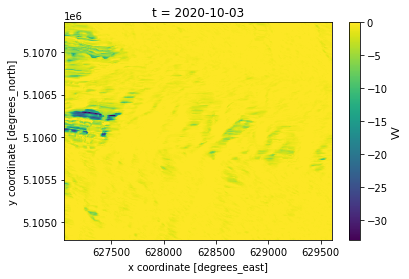

In [56]:
VV_max_t[0].plot()

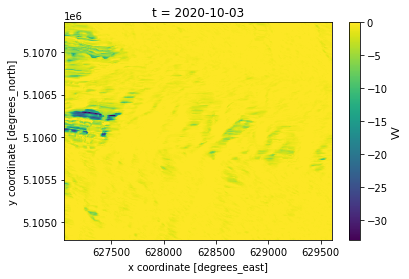

In [50]:
VV_merge = xr.open_dataset('S1_merge_cubes/openEO.nc')
VV_merge.VV[0].plot()

In [22]:
results.download_files('result_0')

[PosixPath('result_0/openEO.nc')]

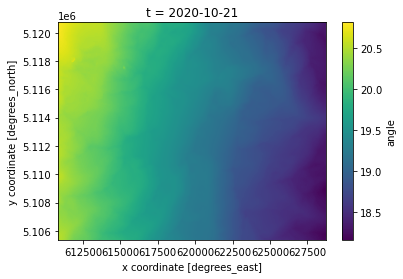

In [37]:
(xr.open_dataset('result_0/openEO.nc').angle[3]/1000).plot()

### Download complete result with metadata and source files
CARD4L results contain STAC metadata and the requested image. 

We can simply download everything, for inspection. Please note: this will download also the original S1 GRD files, which can take a lot of time for a big area or a timeseries.

In [ ]:
# results.download_files()

The downloaded data can be opened, but these are fairly large files, making visualization more difficult.

The foreseen way of interacting with it is to use openEO to further process the dataset into a more manageable result.

In [26]:
# sar = xr.open_rasterio('s1_rtc_02F8D2_N46E011_2021_01_02_MULTIBAND.tif')
# sar

<xarray.DataArray (band: 4, y: 5000, x: 5000)>
[100000000 values with dtype=float32]
Coordinates:
  * band     (band) int64 1 2 3 4
  * y        (y) float64 47.0 47.0 47.0 47.0 47.0 ... 46.0 46.0 46.0 46.0 46.0
  * x        (x) float64 11.0 11.0 11.0 11.0 11.0 ... 12.0 12.0 12.0 12.0 12.0
Attributes:
    transform:               (0.0002, 0.0, 11.0, 0.0, -0.0002, 47.0)
    crs:                     +init=epsg:4326
    res:                     (0.0002, 0.0002)
    is_tiled:                1
    nodatavals:              (nan, nan, nan, nan)
    scales:                  (1.0, 1.0, 1.0, 1.0)
    offsets:                 (0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

### Output visualization

In [88]:
S1_ard = xr.open_dataset("./data/US3/card4l_out.nc")
S1_ard

<xarray.Dataset>
Dimensions:                (t: 2, x: 1280, y: 1024)
Coordinates:
  * t                      (t) datetime64[ns] 2021-01-08 2021-01-07
  * x                      (x) float64 6.733e+05 6.733e+05 ... 6.861e+05
  * y                      (y) float64 5.156e+06 5.156e+06 ... 5.146e+06
Data variables:
    crs                    |S1 ...
    VV                     (t, y, x) float32 ...
    VH                     (t, y, x) float32 ...
    mask                   (t, y, x) float32 ...
    local_incidence_angle  (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.8
    institution:  openEO platform

Text(0.5, 1.0, 'VH gamma0')

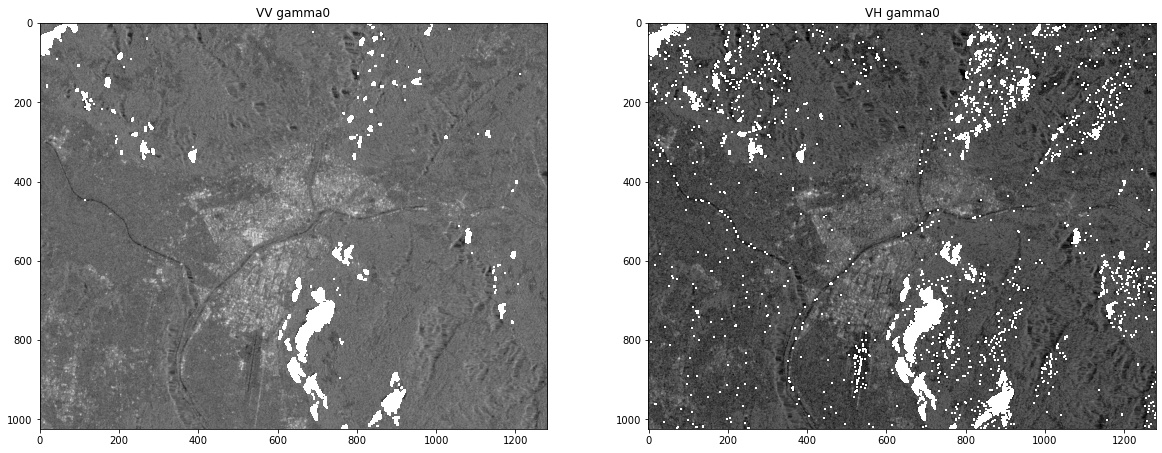

In [107]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))
ax1.imshow(S1_ard.VV[0].values,cmap='Greys_r',vmin=-30,vmax=30)
ax1.set_title('VV gamma0')
ax2.imshow(S1_ard.VH[0].values,cmap='Greys_r',vmin=-30,vmax=30)
ax2.set_title('VH gamma0')

## If we don't need CARDL compliant data, we can also use the sar_backscatter process:

In [93]:
collection      = 'SENTINEL1_GRD'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':'EPSG:4326'}
temporal_extent = ["2021-01-07", "2021-01-08"]
bands           = ["VV","VH"]

s1 = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

### Sigma0:

In [94]:
s1_sigma = s1.sar_backscatter(coefficient='sigma0-ellipsoid').apply(lambda x: 10 * x.log(base=10))

In [95]:
%time s1_sigma.download("./data/US3/s1_sigma.nc",format="NetCDF")

Wall time: 2min 46s


### Gamma0:

In [96]:
s1_gamma = s1.sar_backscatter(coefficient='gamma0-ellipsoid').apply(lambda x: 10 * x.log(base=10))

In [97]:
%time s1_gamma.download("./data/US3/s1_gamma.nc",format="NetCDF")

Wall time: 2min 47s


In [8]:
s1_sigma0 = xr.open_dataset('./data/US3/s1_sigma.nc')
s1_gamma0 = xr.open_dataset('./data/US3/s1_gamma.nc')

Text(0.5, 1.0, 'Sigma VH')

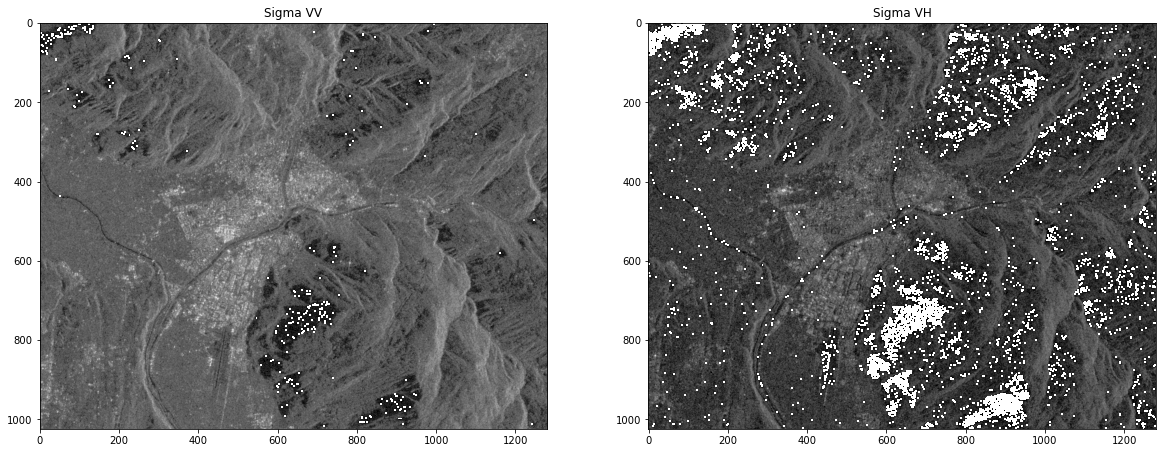

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))

ax1.imshow(s1_sigma0.VV[1].values,cmap='Greys_r',vmin=-30,vmax=30)
ax1.set_title('Sigma VV')
ax2.imshow(s1_sigma0.VH[1].values,cmap='Greys_r',vmin=-30,vmax=30)
ax2.set_title('Sigma VH')

Text(0.5, 1.0, 'Gamma VH')

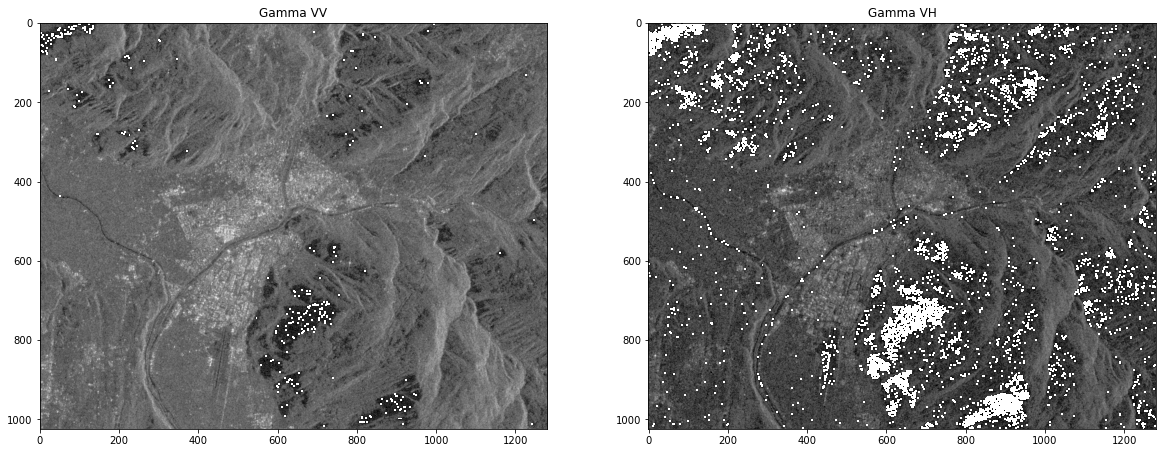

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))

ax1.imshow(s1_gamma0.VV[1].values,cmap='Greys_r',vmin=-30,vmax=30)
ax1.set_title('Gamma VV')
ax2.imshow(s1_gamma0.VH[1].values,cmap='Greys_r',vmin=-30,vmax=30)
ax2.set_title('Gamma VH')

### Sigma To Gamma Ratio

Text(0.5, 1.0, 'Sigma/Gamma VH')

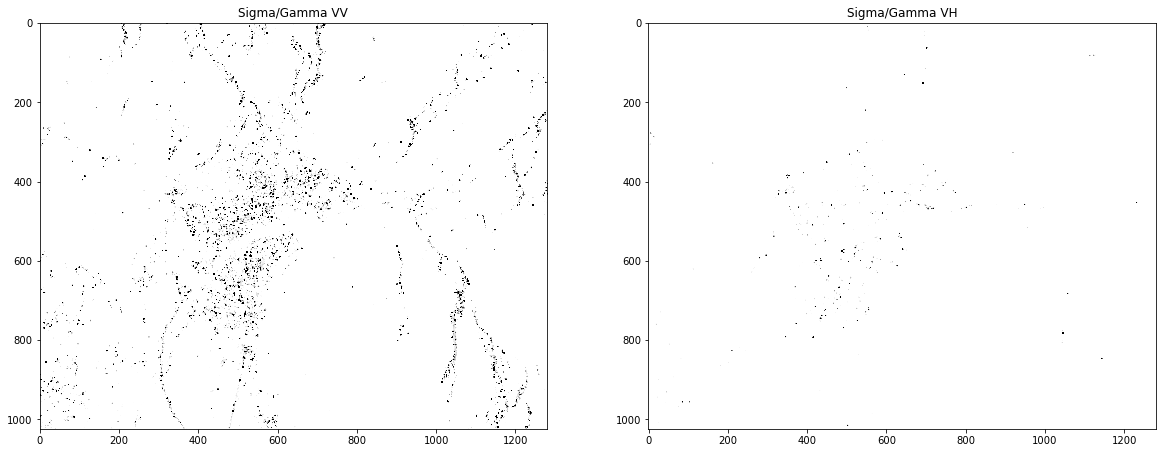

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))

ax1.imshow(s1_sigma0.VV[0].values/s1_gamma0.VV[0].values,cmap='Greys_r',vmin=0,vmax=1)
ax1.set_title('Sigma/Gamma VV')
ax2.imshow(s1_sigma0.VH[0].values/s1_gamma0.VH[0].values,cmap='Greys_r',vmin=0,vmax=1)
ax2.set_title('Sigma/Gamma VH')

## Timeseries comparison

In [12]:
backend = "https://openeo.cloud"
conn = openeo.connect(backend).authenticate_oidc("egi")

Authenticated using refresh token.


In [13]:
W, S = 510000, 5680000
bbox = {
    "west": W, "east": W + 32 * 10,
    "south": S, "north": S + 32 * 10,
    "crs": 32631
}

dates = ("2020-05-06T00:00:00", "2020-09-30T00:00:00")

In [58]:
def backscatter(connection):
    return (connection.load_collection("SENTINEL1_GRD",spatial_extent=bbox,temporal_extent=dates,bands=["VV","VH"])
    .sar_backscatter(coefficient="sigma0-ellipsoid")
    .apply(lambda x: 10 * x.log(base=10)))

In [219]:
%%time
backscatter(conn).download("./data/US3/shub-series.nc", format="NetCDF")

CPU times: user 32 ms, sys: 12 ms, total: 44 ms
Wall time: 15.1 s


In [220]:
%%time
asc = (conn.load_collection("S1_GRD_SIGMA0_ASCENDING").filter_bbox(**bbox)
    .filter_temporal(dates)
    .filter_bands(["VH", "VV"]))
desc = (conn.load_collection("S1_GRD_SIGMA0_DESCENDING").filter_bbox(**bbox)
    .filter_temporal(dates)
    .filter_bands(["VH", "VV"]))
desc.merge_cubes(asc,overlap_resolver="max").apply(lambda x: 10 * x.log(base=10)).download("./data/US3/snap-series.nc", format="NetCDF") 

CPU times: user 20 ms, sys: 8 ms, total: 28 ms
Wall time: 14 s


In [14]:
shub_ts = xr.open_dataset("./data/US3/shub-series.nc")
snap_ts = xr.open_dataset("./data/US3/snap-series.nc")

Compute the mean value, for each timestamp. OpenEO can also do this for you.

In [15]:
xr.merge([shub_ts.rename({"VV": "VV_SHUB", "VH":"VH_SHUB"}), snap_ts.rename({"VV": "VV_SNAP", "VH":"VH_SNAP"})]).mean(dim=['x','y']).hvplot(width=1000,height=600)

:NdOverlay   [Variable]
   :Curve   [t]   (value)

<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/Sentinel_1.jpg"
     alt="Sentinel-1"
     style="float: left; margin-right: 10px; width:100px" />
## CARD4L ARD Sentinel-1 processed with SNAP

Connect to openEO Platform and authenticate using EGI

In [16]:
backend = "https://openeo.cloud"
conn = openeo.connect(backend).authenticate_oidc(provider_id='egi')

Authenticated using refresh token.


Explore the pre-computed data and find the available dates over our area of interest:

In [11]:
itemIter = conn.collection_items(
    "gamma0_sentinel_1_dv",
    temporal_extent = ["2017-03-14", "2017-03-21"],
    spatial_extent = bbox
)

In [12]:
next(itemIter)

{'features': [{'assets': {'card4l': {'href': '/eodc/private/openeo_platform/data/level2/T1/S1/temp/bf9ea5c3-5449-4306-9f40-51f35d2094b5/S1B_IW_GRDH_1SDV_20170317T052620_20170317T052645_004744_008495_76C1/S1B__IW___D_20170317T052620_NR_Orb_TF_TC_proc.xml',
     'roles': ['card4l', 'metadata'],
     'type': 'application/xml'},
    'data_mask': {'file:bits_per_sample': 32,
     'file:byte_order': 'little-endian',
     'file:data_type': 'uint32',
     'file:values': [{'summary': 'No data value.', 'values': [0]}],
     'href': '/eodc/private/openeo_platform/data/level2/T1/S1/EQUI7_EU010M/E047N013T1/S1B__IW___D_20170317T052620_DVV_NR_Orb_TF_TC_EU010M_E047N013T1.tif',
     'roles': ['data-mask', 'metadata'],
     'type': 'image/tiff; application=geotiff'},
    'vh': {'created': '2021-05-19T17:31:11.711365+00:00',
     'file:bits_per_sample': 32,
     'file:byte_order': 'little-endian',
     'file:data_type': 'float32',
     'file:nodata': [0.0],
     'file:unit': 'Watt',
     'href': '/eodc/private/openeo_platform/data/level2/T1/S1/EQUI7_EU010M/E047N013T1/S1B__IW___D_20170317T052620_DVH_NR_Orb_TF_TC_EU010M_E047N013T1.tif',
     'roles': ['data', 'backscatter'],
     'sar:polarizations': ['VH'],
     'type': 'image/tiff; application=geotiff'},
    'vv': {'created': '2021-05-19T17:31:11.711365+00:00',
     'file:bits_per_sample': 32,
     'file:byte_order': 'little-endian',
     'file:data_type': 'float32',
     'file:nodata': [0.0],
     'file:unit': 'Watt',
     'href': '/eodc/private/openeo_platform/data/level2/T1/S1/EQUI7_EU010M/E047N013T1/S1B__IW___D_20170317T052620_DVV_NR_Orb_TF_TC_EU010M_E047N013T1.tif',
     'roles': ['data', 'backscatter'],
     'sar:polarizations': ['VV'],
     'type': 'image/tiff; application=geotiff'}},
   'bbox': [9.398568993262119,
    44.62215188268141,
    10.871659690211281,
    45.669999176576496],
   'geometry': {'coordinates': [[[9.398568993262119, 44.62215188268141],
      [9.398568993262119, 45.669999176576496],
      [10.871659690211281, 45.669999176576496],
      [10.871659690211281, 44.62215188268141],
      [9.398568993262119, 44.62215188268141]]],
    'type': 'Polygon'},
   'id': '04faf580-32bd-4af9-a01f-9fde84a153b9',
   'links': [{'href': 'https://ceos.org/ard/files/PFS/SR/v5.0/CARD4L_Product_Family_Specification_Surface_Reflectance-v5.0.pdf',
     'rel': 'card4l-document',
     'type': 'application/pdf'},
    {'href': 'https://sentinel.esa.int/documents/247904/2142675/Sentinel-1-masking-no-value-pixels-grd-products-note',
     'rel': 'noise-removale'},
    {'href': 'https://step.esa.int/main/doc/', 'rel': 'noise-removal'},
    {'href': 'http://step.esa.int/docs/tutorials/S1TBX%20SAR%20Basics%20Tutorial.pdf',
     'rel': 'radiometric-terrain-correction'}],
   'properties': {'card4l:measurement_convention': 'power',
    'card4l:measurement_type': 'gamma0',
    'card4l:noise_removal_applied': True,
    'card4l:orbit_data_source': 'definitive',
    'card4l:pixel_coordinate_convention': 'upper-left',
    'card4l:specification': 'NRB',
    'card4l:specification_version': '5.0',
    'card4l:speckle_filtering': None,
    'constellation': 'sentinel-1',
    'datetime': '2017-03-17T05:26:20',
    'end_datetime': '2017-03-17T05:26:45',
    'gsd': 10.0,
    'instruments': ['c-sar'],
    'platform': 'sentinel-1b',
    'processing:facility': 'EODC-cloud',
    'processing:software': {'SNAP': '7.0'},
    'proj:epsg': None,
    'proj:wkt2': 'PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]',
    'sar:center_frequency': 5.405,
    'sar:frequ

[1] Define range of interest in time for Sentinel-1

In [14]:
collection      = 's1a_csar_grdh_iw'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':'EPSG:4326'}
temporal_extent = ["2017-03-19", "2017-03-19"]
bands           = ["VV+VH"]

s1 = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

[2] Apply the CARDL compliant SAR processing.

In [15]:
s1bs = s1.ard_normalized_radar_backscatter(elevation_model="COPERNICUS_30")
# s1bs = s1.sar_backscatter()

[3] Save process as final step, here we use GeoTIFF as output format.

In [16]:
s1bs_tif = s1bs.save_result(format="GTiff")

[4] Now we will create a batch job and start it.

In [ ]:
job_snap = conn.create_job(s1bs_tif)
job_id_snap = job_snap.job_id
if job_id_snap:
    print("Batch job created with id: ",job_id_snap)
    job_snap.start_job()
else:
    print("Error! Job ID is None")

In [ ]:
job_snap = eodc_conn.job(job_id_snap)
job_description = job_snap.describe_job()
print("Batch job with id: ",job_id_snap, ' is ',job_description['status'])

In [ ]:
results = job_snap.get_results()
results

In [ ]:
results.download_file("./data/US3/card4l_snap.tif")

### Output visualization

In [242]:
S1_ard_snap = xr.open_dataset("./data/US3/card4l_snap.tif")
S1_ard_snap

<xarray.Dataset>
Dimensions:                (t: 2, x: 918, y: 732)
Coordinates:
  * t                      (t) datetime64[ns] 2021-01-07 2021-01-08
  * x                      (x) float64 6.732e+05 6.732e+05 ... 6.823e+05
  * y                      (y) float64 5.148e+06 5.148e+06 ... 5.156e+06
Data variables:
    VH                     (t, y, x) float32 ...
    VV                     (t, y, x) float32 ...
    local_incidence_angle  (t, y, x) float32 ...
    mask                   (t, y, x) float32 ...
Attributes:
    nodata:   0.0
    crs:      +proj=utm +zone=32 +datum=WGS84 +units=m +no_defs

Text(0.5, 1.0, 'VH gamma0')

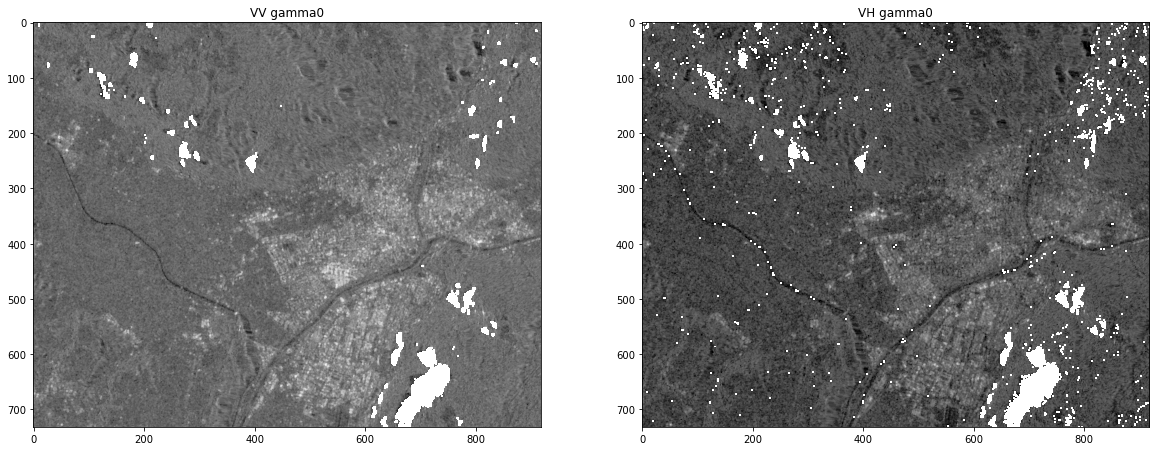

In [245]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))
ax1.imshow(np.flipud(10* np.log10(S1_ard_snap.VV[1].values)),cmap='Greys_r',vmin=-30,vmax=30)
ax1.set_title('VV gamma0 SNAP')
ax2.imshow(np.flipud(10* np.log10(S1_ard_snap.VH[1].values)),cmap='Greys_r',vmin=-30,vmax=30)
ax2.set_title('VH gamma0 SNAP')